## Lab 1: CNN
Jonas Nockert, jonasnockert@gmail.com

Here, I will use [Keras functional API](https://keras.io/getting-started/functional-api-guide/) to, first, construct a few smaller networks to examine the effects of batch normalization, data augmentation and regularization on classifying the [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset. Then I will extend/modify the [MobileNetV2](https://arxiv.org/abs/1801.04381) network with corresponding pre-trained weights in order be able to train on and perform the same classification task. Finally, I will investigate visualizing convolutional layers in order to get a better feel for what it is the network is learning.

Note that I'm using Keras with [PlaidML](https://github.com/plaidml/plaidml) in order to be able to use an AMD Radeon graphics card for training in OSX.

Neither of my networks in this lab are very accurate but most reaches > 90%, which is the passing criterium for the lab.

In [1]:
from math import ceil
import os
import platform

# Set the Keras backend to use plaidml instead of Tensorflow.
# It's not a 1:1 implementation of everything so some parts
# are missing, see last section of the lab. One notable example
# is that one cannot use Tensorboard with PlaidML.
# import plaidml.keras
# os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras import backend as K
from keras.callbacks import (
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from keras.datasets import fashion_mnist
from keras.layers import (
    Activation,
    AveragePooling2D,
    BatchNormalization,
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling2D,
    Input,
    MaxPooling2D,
)
from keras.models import load_model, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

# There's a bug in the latest tk/matplotlib release so this
# workaround is needed (https://github.com/matplotlib/matplotlib/issues/12074).
if platform.system() == "Darwin":
    import matplotlib
    matplotlib.use("MacOSX")
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
# Set the below to None to use default 224x224 weights.
IMAGENET_WEIGHTS_PATH = "/Users/lemonad/.keras/models/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_96_no_top.h5"

# Set Seaborn plotting defaults.
sns.set()
sns.set_palette("RdBu")

Using TensorFlow backend.
/Users/lemonad/.local/share/virtualenvs/lab1--8DOQkvg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/lemonad/.local/share/virtualenvs/lab1--8DOQkvg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/lemonad/.local/share/virtualenvs/lab1--8DOQkvg/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 =

In [2]:
# Load dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
labels = np.array([
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
])

### What does the Fashion MNIST dataset look like?

In [3]:
print("There are {:d} examples in the training set and {:d} in the test set.".format(
    len(train_labels), len(test_labels)))

print("The raw labels are {:s} ...".format(str(np.unique(train_labels))))
print("... which corresponds to labels {:s}".format(str(labels[np.unique(train_labels)])))

There are 60000 examples in the training set and 10000 in the test set.
The raw labels are [0 1 2 3 4 5 6 7 8 9] ...
... which corresponds to labels ['T-shirt/top' 'Trouser' 'Pullover' 'Dress' 'Coat' 'Sandal' 'Shirt'
 'Sneaker' 'Bag' 'Ankle boot']


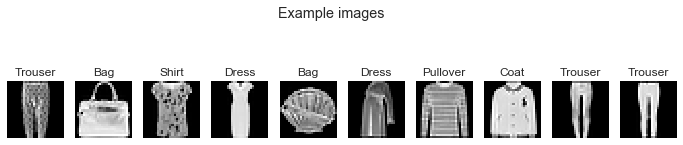

Text(0.5, 0.98, 'Distribution of categories in Fashion-MNIST')

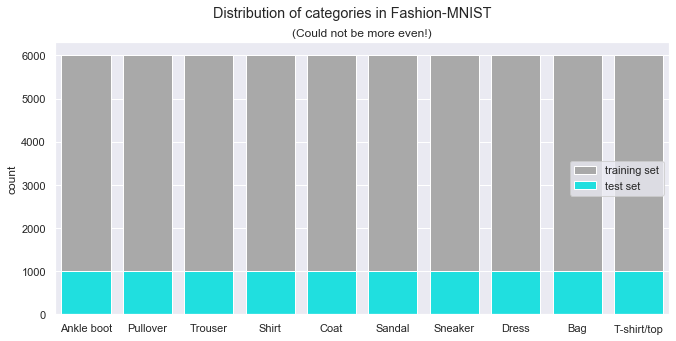

In [4]:
# Plot some example images.
fig = plt.figure(figsize=(12, 3))
indices = np.random.randint(0, len(train_labels), 10)
for i, index in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(train_images[index], cmap="gray"), plt.axis("off")
    plt.title(labels[train_labels[index]])
fig.suptitle("Example images")
plt.show()

# Plot the distribution of categories.
fig = plt.figure(figsize=(11, 5))
sns.countplot(labels[train_labels[:]], color="darkgrey", label="training set");
sns.countplot(labels[test_labels[:]], color="cyan", label="test set");
plt.title("(Could not be more even!)");
plt.legend(loc="center right");
fig.suptitle("Distribution of categories in Fashion-MNIST")

### Extract part of the training dataset to use as validation set
The validation set will be used to keep track of training performance, enabling the test to be left unseen until satisfied with the model. This way avoids using the test set performance to inadvertently guide hyperparameter tuning (and thus the risk of overfitting to the test set). A rule of thumb is to use an 80/20 split, which is what is used here, based mainly on having neither particularly small nor particularly large dataset.

In [5]:
# Reshape from (60000, 28, 28) to (60000, 28, 28, 1), i.e. channels last format.
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
test_images = test_images.reshape((test_images.shape[0], 28, 28, 1))

# To be safe, it's best to permute the training set before splitting into two
# (validation, training), otherwise we might end up with unbalanced subsets
# (e.g. mostly nines in the validation set and few nines in the training set).
perm = np.random.permutation(len(train_images))
train_images = train_images[perm]
train_labels = train_labels[perm]
val_images = train_images[-12000:]
val_labels = train_labels[-12000:]
train_images = train_images[:-12000]
train_labels = train_labels[:-12000]

### Code for convolutional network model, training, evaluation and plotting
ReLU activation functions will be used throughout for activations following convolutional layers.

In [6]:
class MnistModel:
    def __init__(self, image_size, config):
        self._input_shape = (image_size[0], image_size[1], 1)
        self.config = config

    def __call__(self):
        inputs = Input(shape=self._input_shape, name="img")

        # Keras functional API is used here but a simpler Sequential model
        # could equally well have been used in this case.
        x = Conv2D(
            # Number of output filters. In convolutional networks this
            # generally grows and the image sizes shrink later in the
            # network compared to the beginning.
            32,
            # For each pixel, take into account all the immediate neighbors
            # when convolving the image.
            kernel_size=(3, 3),
            # Keras allows the specification of which weight initializers to
            # use and the below is mostly for show given the size and complexity
            # of our convolutional network.
            # https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf
            kernel_initializer="he_normal",
            input_shape=self._input_shape,
            # (28, 28, 1) rather than channels first (1, 28, 28).
            data_format="channels_last",
            # Since the images are so small, pad them in order to not lose too
            # many pixels at the edges during the convolution steps.
            padding="same", 
            # The names will be used for reference in the visualization part
            # at the end of the lab.
            name="cv1",
        )(inputs)
        # The activations can be split out explicitly into a separate step like this
        # (or the activation function to use can be given as a parameter to Conv2D).
        # ReLU is a pretty much the simplest non-linear activation function but is
        # surprisingly effective (e.g. https://ieeexplore.ieee.org/document/8404724)
        x = Activation("relu", name="act1")(x)
        if self.config.batch_norm:
            # Optional batch normalization which will be examined later in the lab.
            x = BatchNormalization(name="bn1")(x)
        x = Conv2D(32, kernel_size=(3, 3), kernel_initializer="he_normal", name="cv2")(x)
        x = Activation("relu", name="act2")(x)
        if self.config.batch_norm:
            x = BatchNormalization(name="bn2")(x)
        # Use a pooling layer to pick out the maximum activations and
        # halve the spatial size of the network (i.e. the default is a
        # stride the same size as the pool).
        x = MaxPooling2D(pool_size=(2, 2), name="mp1")(x)

        x = Conv2D(64, kernel_size=(3, 3), kernel_initializer="he_normal", padding="same", name="cv3")(x)
        x = Activation("relu", name="act3")(x)
        x = MaxPooling2D(pool_size=(2, 2), name="mp2")(x)
        if self.config.batch_norm:
            x = BatchNormalization(name="bn3")(x)

        # Optional dropout for regularization.
        x = Dropout(self.config.dropout1, name="drop1")(x)
        # Flatten 3D tensor into a 1D tensor.
        # I like being explicit but it should be noted that Keras seems to do
        # this implicitly in the Dense layer if rank is > 2.
        x = Flatten(name="flt")(x)
        x = Dense(self.config.dense_layer_size, name="dense1")(x)
        x = Activation("relu", name="act4")(x)
        # Optional dropout for regularization. This removes nodes and their
        # related connections randomly according to the rate given. A rate
        # of 0.5 will drop half of the nodes.
        x = Dropout(self.config.dropout2, name="drop2")(x)
        # Output normalized probabilities for each of our 10 garment classes.
        # That is, given an image, the network will output a 0-1 probability
        # per class for the image being of the corresponding class. Multiple
        # outputs can have >0 probability but the probabilities sum to 1.
        outputs = Dense(10, activation="softmax", name="out")(x)

        model = Model(inputs=inputs, outputs=outputs, name="model")
        return model

In [7]:
class Config:
    """Configuration/default configuration for a network."""
    def __init__(
        self,
        learning_rate=1e-4,
        epochs=15,
        batch_size=32,
        seed=42,
        batch_norm=False,
        auto_reduce_learning_rate=True,
        dropout1=0.0,
        dropout2=0.0,
        dense_layer_size=128,
        augment_hflip=False,
        augment_vflip=False,
        augment_rotation=False,
        augment_shift=False,
        augment_shear=False,
        augment_zoom=False,
        model_path="fashion-mnist-model.h5",
        freeze_before_block=None
    ):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.seed = seed
        self.batch_norm = batch_norm
        self.dropout1 = dropout1
        self.dropout2 = dropout2
        self.dense_layer_size = dense_layer_size
        self.augment_hflip = augment_hflip
        self.augment_vflip = augment_vflip
        self.augment_rotation = augment_rotation
        self.augment_shift = augment_shift
        self.augment_shear = augment_shear
        self.augment_zoom = augment_zoom
        self.model_path=model_path
        self.auto_reduce_learning_rate=auto_reduce_learning_rate
        self.freeze_before_block=freeze_before_block

In [8]:
def train(config, X, y, X_val, y_val, custom_model=None):
    """Given training and validation data, returns trained model and training data.
    
    Can also take a custom model (used when exploring transfer learning).
    """
    augmentation_params = {}
    if config.augment_hflip:
        augmentation_params["horizontal_flip"] = True
    if config.augment_vflip:
        augmentation_params["vertical_flip"] = True
    if config.augment_rotation:
        augmentation_params["rotation_range"] = 10
    if config.augment_shift:
        augmentation_params["width_shift_range"] = 0.1
        augmentation_params["height_shift_range"] = 0.1
    if config.augment_shear:
        augmentation_params["shear_range"] = 0.1
    if config.augment_zoom:
        augmentation_params["zoom_range"] = 0.1

    # Image data generators are used here to process images before they
    # are used for training or validation.
    train_datagen = ImageDataGenerator(
        dtype="float32", rescale=1.0 / 255,  # Use 0-1 floats rather than 0-255 integers.
        **augmentation_params,
    )

    # Note that we do not want to augment the validation set as we want it to
    # have the same distribution as the test set.
    validation_datagen = ImageDataGenerator(dtype="float32", rescale=1.0 / 255)

    train_generator = train_datagen.flow(
        X, y, batch_size=config.batch_size, seed=config.seed
    )
    validation_generator = validation_datagen.flow(
        X_val, y_val, batch_size=config.batch_size, seed=config.seed
    )

    if custom_model:
        model = custom_model((32, 32), config)()
    else:
        model = MnistModel((28, 28), config)()

    model.compile(
        # Adam seems to be a generally good choice of
        # optimizer that can be used with everything set
        # to default. I'm setting the initial learning rate
        # manually but as the learning rate is adaptive it
        # should not be needed.
        optimizer=Adam(lr=config.learning_rate),
        # Using categorical crossentropy loss function since this
        # is a multi-class classification task. The `sparse` variants
        # lets us use multiple outputs (i.e. the Dense(10) layer)
        # from the model together with integer 0-9 labels.
        loss=["sparse_categorical_crossentropy"],
        metrics=["sparse_categorical_accuracy"],
    )
    # Show information about the model we've built.
    model.count_params()
    model.summary()

    # If we only save the model after training we risk saving a model that's been
    # overfitted to the training data and not the "best" model we've seen during
    # training. Of course, the best model in this case is the one that gives the best
    # result on the (unseen) test data. Here we save the model that has the lowest
    # validation loss with the assumption that this is a good proxy to getting the
    # lowest loss on the test set as well.
    checkpoint = ModelCheckpoint(
        "best-{}".format(config.model_path),
        save_weights_only=False,
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        mode="auto",
    )
    callbacks = [checkpoint]

    # This callback basically lets us use a high(er) learning rate
    # initially and when the performance does not improve for a
    # number of iterations, the learning rate is gradually lowered.
    # This can potentially help break out of local optima or divergence
    # but the general inituition is that large adjustments to the weights
    # are necessary initially while fine-tuning is more appropriate in
    # later stages of training.
    #
    # Note that since Adam uses an adaptive learning rate, I'm not sure
    # how much this will help in practice in this specific case (if it helps
    # at all).
    if config.auto_reduce_learning_rate:
        lr_reducer = ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-5
        )
        callbacks.append(lr_reducer)
    
    history = model.fit_generator(
        train_generator,
        epochs=config.epochs,
        # As I understand it -- with augumentation, the `steps` parameters are
        # less crucial but without augmentation we really want to get this right.
        # Given 48000 training samples (given a 80/20 validation split) and batch
        # size of 64, we should run exactly 750 rounds to complete an epoch. If we
        # run fewer some images might never be trained on and if we run more,
        # some images might be seen twice as many times as the rest (skewing the
        # distribution).
        #
        # The parameter `shuffle` is true as default but I believe this parameter
        # is ignored when using an image data generator as is the case here.
        #
        # Note that augmentation does not add "extra" augmented samples but instead
        # randomly augments all images. That is, we do not need to adjust parameters
        # due to augmentation.
        steps_per_epoch=ceil(train_generator.n / config.batch_size),
        validation_data=validation_generator,
        validation_steps=ceil(validation_generator.n / config.batch_size),
        callbacks=callbacks,
        verbose=2,
    )

    # Save final model (not necessarily as good as the "best" model saved during
    # checkpoints.
    model.save(config.model_path)
    return model, history

In [9]:
def plot_results(history, title=None):
    """Plot training loss and accuracy."""
    acc = history.history["sparse_categorical_accuracy"]
    val_acc = history.history["val_sparse_categorical_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    print("---")
    print("Best accuracy: {:f} (trn, epoch {:d}), {:f} (val, epoch {:d})".format(
        np.max(acc),
        np.argmax(acc),
        np.max(val_acc),
        np.argmax(val_acc)
    ))
    print("Best loss: {:f} (trn, epoch {:d}), {:f} (val, epoch {:d})".format(
        np.min(loss),
        np.argmin(loss),
        np.min(val_loss),
        np.argmin(val_loss)
    ))

    epochs = range(1, len(loss) + 1)
    fig = plt.figure(figsize=(11, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, "b--", label="Training")
    plt.plot(epochs, val_acc, "b", label="Validation")
    plt.axhline(y=0.9, color="green", linestyle="--")
    plt.title("Training and validation Accuracy")
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "r--", label="Training")
    plt.plot(epochs, val_loss, "r", label="Validation")
    plt.title("Training and validation loss")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    if title:
        fig.suptitle(title)
    plt.show()

In [11]:
def evaluate(model_path, X_test, y_test):
    """Given test data, evaluates the performance of a (saved) "best" model."""
    # The data was rescaled to 0-1 floats in the image generation phase so
    # need to do the same with the test images. Otherwise, the test set does
    # not represent the same type of data we've been training our model on and
    # the performance will always be poor.
    #
    # Note that the models are saved to disk during training and are
    # loaded here for evaluation purposes.
    best_model = load_model("best-{}".format(model_path))
    results = best_model.evaluate(X_test / 255.0, y_test, verbose=0)
    print("Performance on test set for the \"best\" model seen during training:")
    print("-- accuracy: {:.3f}, loss: {:.3f}".format(results[1], results[0]))
    if results[1] > 0.9:
        print("😀 Achieved lab criteria of at least 90% correct on the test data! 😅")
    else:
        print("😱 Less than 90% correct on the test data! 😢")

### Train initial model
As a baseline, the model is trained without regularization, augmentation and batch normalization. The next step is to add batch normalization for comparison (more on that below).

The learning rate is set low so it will be easier to see what's going on (with the downside of long training times).

INFO:plaidml:Opening device "metal_amd_radeon_vii.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
mp1 (MaxPooling2D)           (None, 12, 12, 32)        0         
_________________________________________________________________
cv3 (Conv2D)                 (None, 12, 12, 64)        18496     
__________

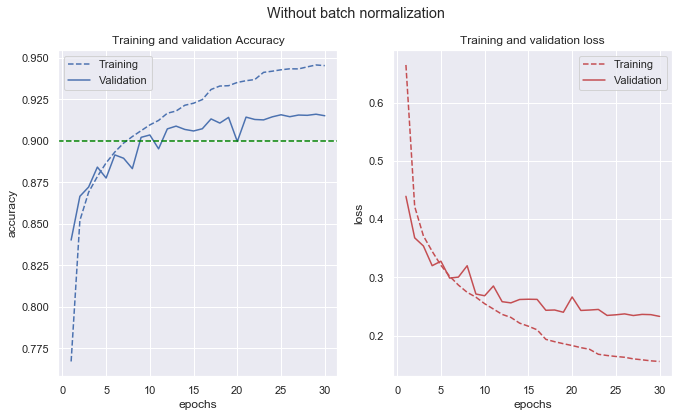

In [12]:
no_batch_norm_model_path="no-batch-norm-model.h5"
config = Config(
    epochs=30,
    batch_size=128,
    learning_rate=1e-4,
    model_path=no_batch_norm_model_path
)
np.random.seed(config.seed)
no_batch_norm_model, no_batch_norm_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(no_batch_norm_history, title="Without batch normalization")

#### Evaluate performance on test set

In [13]:
evaluate(no_batch_norm_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.911, loss: 0.264
😀 Achieved lab criteria of at least 90% correct on the test data! 😅


#### Conclusion
Here, the model is overfitting to the training set and what the network ends up learning can't be expected to generalize. The performance gap between training and validation keeps increasing after >6 epochs, which is an indication that (a) there is potential for improving the performance of the model on the validation set (and thus the test set), and (b) we might benefit from introducing some form of regularization to make it a little harder for the network to learn the specifics of the training set.

Before adding regularization, lets see what happens if we perform batch normalization after every convolutional layer. There are many subleties but essentially, without batch normalization, the effects of changing an early layer's weights depends much on later layers' weights which makes the network difficult to optimize. With batch normalization, the effects are more controlled and training can become more effective (cf. [Busting the myth about batch normalization](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/), [Ian Goodfellow lectures about Batch Normalization](https://www.youtube.com/watch?v=Xogn6veSyxA)).

### Train model with batch normalization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 24, 24, 32)        128       
__________

INFO:plaidml:Analyzing Ops: 210 of 518 operations complete


 - 33s - loss: 0.5317 - sparse_categorical_accuracy: 0.8125 - val_loss: 0.4998 - val_sparse_categorical_accuracy: 0.8167

Epoch 00001: val_loss improved from inf to 0.49982, saving model to best-batch_norm_model.h5
Epoch 2/30
 - 28s - loss: 0.3191 - sparse_categorical_accuracy: 0.8869 - val_loss: 0.3054 - val_sparse_categorical_accuracy: 0.8882

Epoch 00002: val_loss improved from 0.49982 to 0.30544, saving model to best-batch_norm_model.h5
Epoch 3/30
 - 28s - loss: 0.2645 - sparse_categorical_accuracy: 0.9060 - val_loss: 0.2796 - val_sparse_categorical_accuracy: 0.8978

Epoch 00003: val_loss improved from 0.30544 to 0.27960, saving model to best-batch_norm_model.h5
Epoch 4/30
 - 27s - loss: 0.2291 - sparse_categorical_accuracy: 0.9179 - val_loss: 0.2683 - val_sparse_categorical_accuracy: 0.9032

Epoch 00004: val_loss improved from 0.27960 to 0.26825, saving model to best-batch_norm_model.h5
Epoch 5/30
 - 27s - loss: 0.2032 - sparse_categorical_accuracy: 0.9283 - val_loss: 0.2624 - val

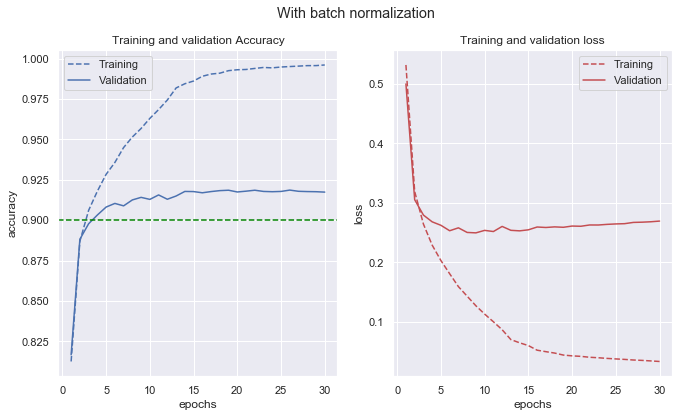

In [14]:
batch_norm_model_path="batch_norm_model.h5"
config = Config(
    epochs=30,
    learning_rate=1e-4,
    batch_size=128,
    batch_norm=True,
    model_path=batch_norm_model_path
)
np.random.seed(config.seed)
batch_norm_model, batch_norm_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(batch_norm_history, title="With batch normalization")

In [15]:
evaluate(batch_norm_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.905, loss: 0.274
😀 Achieved lab criteria of at least 90% correct on the test data! 😅


#### Conclusion
The performance on the validation set is not much different but the curves are smoother and the learning is much more effective. After only about 3 epochs we reach >90% accuracy and it seems like we could increase the learning rate a bit without sacrificing stability. The validation loss ramps up as training loss decreases due to the model overfitting to the training data and not generalizing to the validation set.

_Sidenote_: both the validation accuracy and loss increase after epoch ~10! One explanation could be that while the network overfits to the training images, this still results in more validation images being classified correctly — but with more uncertainty.

The gap between training and validation sets are now substantial and we should try introducing regularization the network. Since we have batch normalization in place, we can try augmentation as a way to virtually increase the number of training examples as an alternative means to explicitly regularizing the network through e.g. dropout (cf. [Data augmentation instead of explicit regularization](https://arxiv.org/abs/1806.03852), [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167.pdf)).

### Train model with batch normalization and augmentation
Making no other changes to the hyperparameters.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 26, 26, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 26, 26, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 24, 24, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 24, 24, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 24, 24, 32)        128       
__________

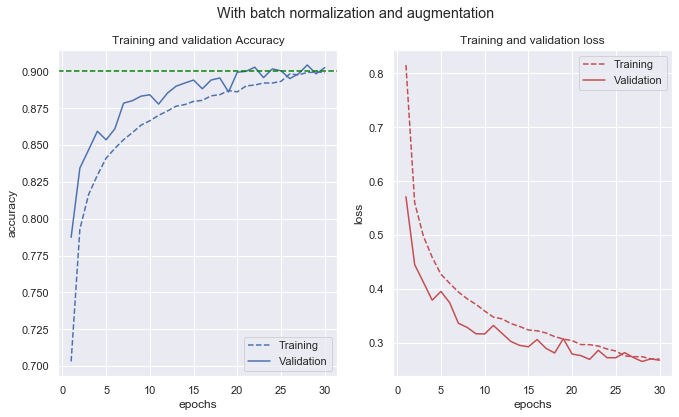

In [16]:
augm_model_path="augm-model.h5"
config = Config(
    epochs=30,
    learning_rate=1e-4,
    batch_size=128,
    batch_norm=True,
    augment_hflip=True,
    augment_zoom=0.1,
    augment_rotation=10,
    augment_shift=0.1,
    model_path=augm_model_path
)
np.random.seed(config.seed)
augm_model, augm_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(augm_history, title="With batch normalization and augmentation")

In [17]:
evaluate(augm_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.898, loss: 0.284


#### Conclusion
All the images in the Fashion-MNIST dataset seems to be axis-aligned and centered so it comes as no large surprise that the performance suffers for both training and validation sets, especially when applying random rotation and shifting. For images in general, augmentation is very useful if applied with care (e.g. one should probably not augment the dataset with upside down images if no such images are expected in the actual data the model will be applied to).

### Train model with (less) augmentation (and some dropout)
As augmentation essentially increases the number of training examples it counteracts overfitting. Removing some of the data augmentation methods used above (like rotation), the model is again likely to overfit and introducing dropout can counteract this (combined with augmentation we need less than we would otherwise). Dropout removes nodes and their connections randomly during training and since the network then cannot rely on any single neuron being there, the idea is that it then develops stronger, more general structures instead of brittle, specific ones honed in on just the training data ([Dropout: A Simple Way to Prevent Neural Networks from Overfitting](http://jmlr.org/papers/v15/srivastava14a.html)).


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             (None, 28, 28, 1)         0         
_________________________________________________________________
cv1 (Conv2D)                 (None, 28, 28, 32)        320       
_________________________________________________________________
act1 (Activation)            (None, 28, 28, 32)        0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 28, 28, 32)        128       
_________________________________________________________________
cv2 (Conv2D)                 (None, 26, 26, 32)        9248      
_________________________________________________________________
act2 (Activation)            (None, 26, 26, 32)        0         
_________________________________________________________________
bn2 (BatchNormalization)     (None, 26, 26, 32)        128       
__________

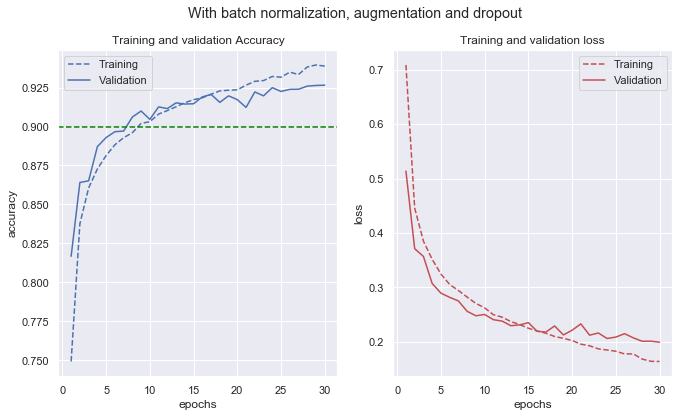

In [65]:
augm_dropout_model_path="augm-dropout-model.h5"
config = Config(
    epochs=30,
    learning_rate=1e-4,
    batch_size=128,
    batch_norm=True,
    dropout1=0.1,
    dropout2=0.1,
    augment_hflip=True,
    augment_zoom=0.1,
    model_path=augm_dropout_model_path
)
np.random.seed(config.seed)
augm_dropout_model, augm_dropout_history = train(
    config,
    train_images,
    train_labels,
    val_images,
    val_labels
)
plot_results(augm_dropout_history, title="With batch normalization, augmentation and dropout")

In [67]:
evaluate(augm_dropout_model_path, test_images, test_labels)

Performance on test set for the "best" model seen during training:
-- accuracy: 0.920, loss: 0.227
😀 Achieved lab criteria of at least 90% correct on the test data! 😅


#### Conclusion
Now, it seems that a reasonable combination of batch normalization, augmentation and dropout has been found and the result is one of the best so far. Actually, one could probably reach even better performance by letting the training continue another ten epochs.

### Transfer learning
Training and hyperparameter optimization take a lot of time. What if one could leverage other people's work, people with a lot more skills in designing good neural networks? Turns out that it is both possible and *generally* a good idea, especially if using a network trained within a similar domain as the dataset in question.

[MobileNetV2](https://ai.googleblog.com/2018/04/mobilenetv2-next-generation-of-on.html) with pre-trained weights from ImageNet is the architecture that will be used here. It's a relatively small network that performs well on mobile devices (computer vision on mobile devices is an area I'm interested in). MobileNet V2 is mainly composed of 16 blocks of layers with shortcut connections between the blocks. These shortcuts essentially help the network to learn the identity function so that having many blocks/layers is less likely to hurt performance. My intuition is that this makes the same network architecture compatible with input on different scales/level of details.

ImageNet is a *huge* dataset consisting of a wide range of color images, which is not a particularly good match with the Fashion-MNIST dataset. This presents a problem as the underlying idea is that since the weights are honed in on extracting features for good classification results on ImageNet, the same features should be useful in the current classification task.

Given this, there are a few choices to make in regards to transfer learning.

* Which layers to keep the ImageNet-based weights fixed for and which layers to retrain for our dataset?
* Should the 1000-category top of MobileNet be replaced with only a 10-category output or also additional (dense) layers?

Given the poor match between ImageNet and our dataset, we probably should retrain at least some of the layers as well as add at least one additional dense layer. Had our dataset been large and our images represented a subset of ImageNet's, we could have opted for fine tuning the network, i.e. retraining the network with a low learning rate, expecting the weights to just change a little. This does not seem like an option here. Of course, we could just retrain the entire network, using the weights as (hopefully) better initialization values than random (but I don't think that can be considered transfer learning).

#### Implementation details and some worries
Our dataset consists of 28x28 grayscale images and MobileNetV2 only accepts larger RGB images so we need to resize/pad our images as well as make them 3-channel RGB. Now, I'm not sure about how it works under the hood but MobileNetV2 accepts 32x32x3 inputs, which is pretty close to what we have. However, there are no weights available for that shape (96x96x3 is the closest choice) so the question is if we would be better off padding/resizing to 96x96 and using matching weights? The network will take much longer to train this way and our padded/resized images will likely be a poor match with these weights anyway.

If we go with 32x32x3 inputs, per default, weights from a 224x224x3-based network will be loaded into layers with matching names. If we want to freeze layers during transfer learning and not all layers match, we might be freezing layers with default weights, which will likely give a poor performance. It is not obvious to me which layers match (perhaps all?) and which do not, although this can surely be found out given additional effort.

In [43]:
class MnistTransferModel:
    def __init__(self, image_size, config):
        self._input_shape = (image_size[0], image_size[1], 3)
        self.config = config
        
    def __call__(self):
        from keras.applications.mobilenet_v2 import MobileNetV2

        inputs = Input(shape=self._input_shape, name="input")
        net = MobileNetV2(
            # None means shape should be inferred from the `input_tensor`.
            input_shape=None,
            input_tensor=inputs,
            alpha=1.0,
            # Exclude the final dense layer(s), i.e. a pooling layer and a
            # 1000-element dense softmax output layer corresponding to imagenet
            # classification in this case.
            include_top=False,
            # weights="imagenet",
            pooling=None,
            # The 224x224 imagenet weights will be used by default and
            # it seems reasonable to use the 96x96 weights for 32x32 images
            # so force this.
            weights="imagenet" if not IMAGENET_WEIGHTS_PATH else IMAGENET_WEIGHTS_PATH,
        )
        
        # MobileNet V2 uses a general "building block" and repeats this
        # 16 times (https://machinethink.net/blog/mobilenet-v2/)
        if self.config.freeze_before_block:
            if self.config.freeze_before_block < 1 or self.config.freeze_before_block > 16:
                print("Block {:d} out of valid range".format(self.config.freeze_before_block))
            else:
                # Starting layers for blocks 1-16.
                block_layers = [
                    10, 19, 28, 37, 46, 55, 64, 73, 82, 91, 99, 108, 117, 126, 135, 144
                ]

                print("Freezing all layers before block {:d}.".format(self.config.freeze_before_block))
                for i, layer in enumerate(net.layers):
                    if i >= block_layers[self.config.freeze_before_block - 1]:
                        layer.trainable = True
                    else:
                        layer.trainable = False

        # Add a custom top to the network.
        x = GlobalAveragePooling2D()(net.output)
        # Flatten used explicitly here but not needed as mentioned above, previously.
        # x = Flatten(name="flt")(net.output)
        if self.config.dense_layer_size > 0:
            x = Dense(self.config.dense_layer_size, name="dense1")(x)
            x = Activation("relu", name="act4")(x)
        x = Dropout(self.config.dropout1, name="drop1")(x)
        outputs = Dense(10, activation="softmax", name="out")(x)

        model = Model(inputs=inputs, outputs=outputs, name="model")
        return model

Freezing all layers before block 13.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input[0][0]                      
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
________________________________________________________________________

INFO:plaidml:Analyzing Ops: 1090 of 2255 operations complete


 - 59s - loss: 1.4769 - sparse_categorical_accuracy: 0.5251 - val_loss: 2.2391 - val_sparse_categorical_accuracy: 0.2398

Epoch 00001: val_loss improved from inf to 2.23908, saving model to best-transfer-model.h5
Epoch 2/20
 - 51s - loss: 0.8461 - sparse_categorical_accuracy: 0.7223 - val_loss: 1.8092 - val_sparse_categorical_accuracy: 0.3851

Epoch 00002: val_loss improved from 2.23908 to 1.80922, saving model to best-transfer-model.h5
Epoch 3/20
 - 51s - loss: 0.7172 - sparse_categorical_accuracy: 0.7640 - val_loss: 1.5308 - val_sparse_categorical_accuracy: 0.5157

Epoch 00003: val_loss improved from 1.80922 to 1.53082, saving model to best-transfer-model.h5
Epoch 4/20
 - 50s - loss: 0.6366 - sparse_categorical_accuracy: 0.7895 - val_loss: 1.6955 - val_sparse_categorical_accuracy: 0.4619

Epoch 00004: val_loss did not improve from 1.53082
Epoch 5/20
 - 50s - loss: 0.5728 - sparse_categorical_accuracy: 0.8088 - val_loss: 1.4469 - val_sparse_categorical_accuracy: 0.5052

Epoch 00005: v

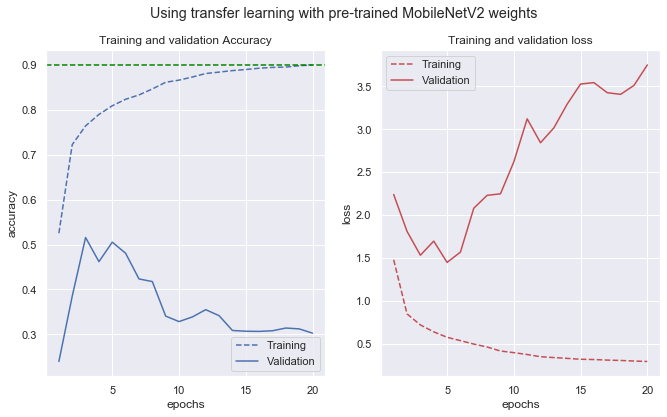

In [46]:
# Pad images with zeros to form 32x32 images as this is the smallest size
# most pre-trained networks in Keras accepts.
padding = (2, 2)
train_images_padded = np.pad(train_images, ((0, 0), padding, padding, (0, 0)), "constant")
val_images_padded = np.pad(val_images, ((0, 0), padding, padding, (0, 0)), "constant")
test_images_padded = np.pad(test_images, ((0, 0), padding, padding, (0, 0)), "constant")

# Stack 3 x grayscale images to form 3-channel "RGB" images as this is what
# pre-trained networks expect.
train_images_padded = np.squeeze(np.stack([train_images_padded] * 3, axis=-1))
val_images_padded = np.squeeze(np.stack([val_images_padded] * 3, axis=-1))
test_images_padded = np.squeeze(np.stack([test_images_padded] * 3, axis=-1))

transfer_model_path="transfer-model.h5"
config = Config(
    epochs=20,
    learning_rate=1e-4,
    batch_size=64,
    dense_layer_size=64,
    dropout1=0.7,
    model_path=transfer_model_path,
    freeze_before_block=13
)
np.random.seed(config.seed)
transfer_model, transfer_history = train(
    config,
    train_images_padded,
    train_labels,
    val_images_padded,
    val_labels,
    custom_model=MnistTransferModel
)
plot_results(transfer_history, title="Using transfer learning with pre-trained MobileNetV2 weights")

In [ ]:
evaluate(transfer_model_path, test_images_padded, test_labels)

#### Conclusion
Using a slow learning rate and massive dropout, initially the results are promising but quickly training and validation performance diverges. Additional hyperparameter optimization would likely lead to better performance overall but I just couldn't find a good combination. In most cases the training performance quickly reaches >80% while the validation performance stays abysmal.

Although not shown here, re-training the network without freezing any layers and without additional dense layer leads to a much better result. This is not very surprising, [people seem to have reached ~95% accuracy using MobileNet](https://kexue.fm/archives/4556).

### Visualizing what convolutional networks learn
#### Visualizing intermediate activations

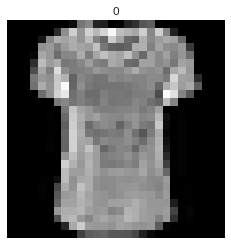

In [109]:
# Get image from test set (unseen during model training)
ix = 488  # an example with high uncertainty
# ix = 999  # an example with low uncertainty
plt.figure()
plt.imshow(test_images[ix].reshape((28, 28)), cmap="gray"), plt.axis("off")
plt.title(test_labels[ix])
plt.show()

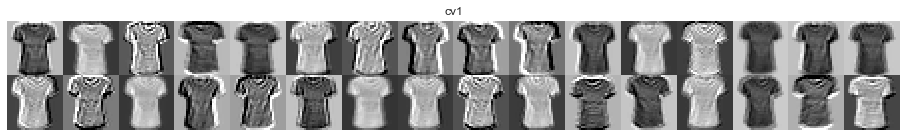

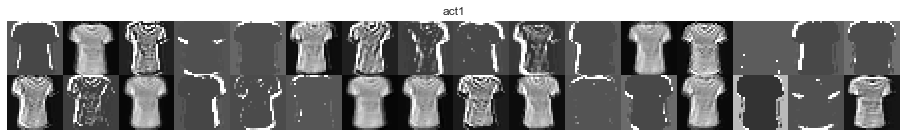

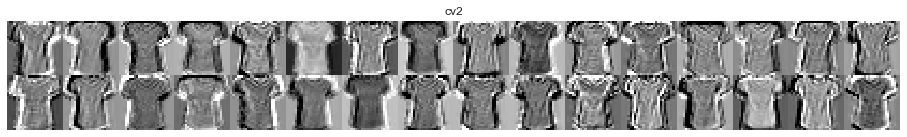

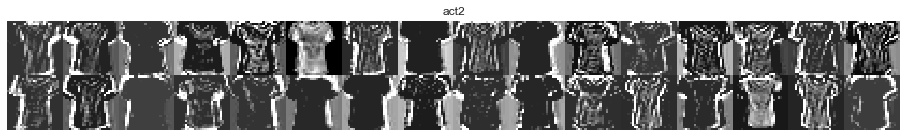

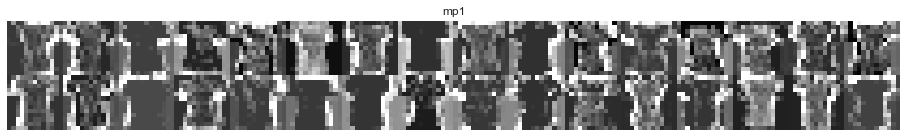

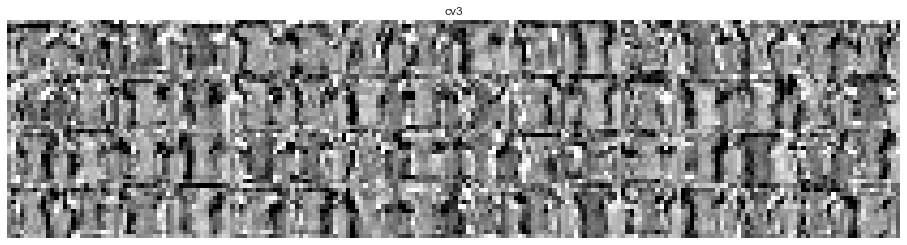

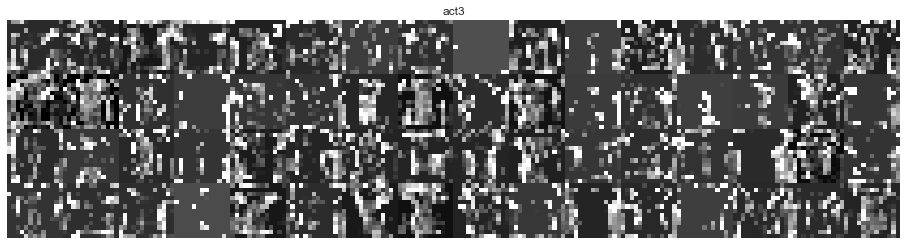

In [112]:
augm_dropout_model_path="augm-model.h5"
best_model = load_model("best-{:s}".format(augm_dropout_model_path))

# Extract the convolutional and activation layers.
relevant_layers = [1, 2, 4, 5, 7, 8, 9]
layer_outputs = [best_model.layers[i].output for i in relevant_layers]
# Create a multi-output model, one for each relevant layer.
activation_model = Model(inputs=best_model.input, outputs=layer_outputs)
# Run the random image from above through the model so we get the
# outputs.
img = np.expand_dims(test_images[ix], axis=0) / 255.0
activations = activation_model.predict(img)

layer_names = []
for i in relevant_layers:
    layer_names.append(best_model.layers[i].name)

images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Standardize image, essentially N(0, 1).
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            # Center around mid-gray value.
            channel_image += 128
            # Clip all values outside 0-255.
            channel_image = np.clip(channel_image, 0, 255).astype("uint8")
            display_grid[
                col * size : (col + 1) * size,
                row * size : (row + 1) * size
            ] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect="auto", cmap="gray")
    plt.axis("off")

#### What does the network think this is?
(In terms of softmax probabilities)

In [113]:
best_model = load_model("best-{:s}".format(augm_dropout_model_path))
best_model = load_model("augm-model.h5")

predictions = best_model.predict(img)
predicted_ix = int(np.argmax(predictions[0]))
predicted_label = labels[predicted_ix]
for label, p in list(zip(labels, predictions[0])):
    print("{:s} {:.4f} {:s}".format(
        label.ljust(12),
        p,
        "<-- predicted label" if predicted_label == label else ""
    ))

T-shirt/top  0.7352 <-- predicted label
Trouser      0.0000 
Pullover     0.0000 
Dress        0.0003 
Coat         0.0000 
Sandal       0.0000 
Shirt        0.2645 
Sneaker      0.0000 
Bag          0.0000 
Ankle boot   0.0000 


Apparently, with this image it is not quite clear if it should be considered a t-shirt/top or a shirt.

#### What "neurons" are activated when classifying this image?
Here, an importance map will be superimposed on the image to see what areas of the image are most important for the network when
coming up with the probability for the prediction with the highest probability, above.

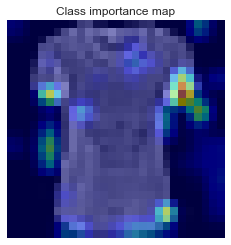

In [120]:
output = best_model.output[:, predicted_ix]
# Get the activation layer from convolutional layer 3.
last_act_layer = best_model.get_layer("act3")
# Get the gradients for the last convolutional layer
# and mean pool them. K is the backend being used
# (tensorflow, plaidml, theanos).
gradients = K.gradients(output, last_act_layer.output)[0]
pooled_gradients = K.mean(gradients, axis=(0, 1, 2))
# Given an input image, get the gradients and activations.
iterate = K.function(
    [best_model.layers[0].input],
    [pooled_gradients, last_act_layer.output[0]]
)
pooled_gradients_value, act_layer_output_value = iterate([img])

# Combine all filters into an importance map for the
# classified image. For each filter, multiply the
# activations by how important it is for making the
# classification.
for i in range(64):
    act_layer_output_value[:, :, i] *= pooled_gradients_value[i]
# Average all filters so we get a 2d importance map.
importance_map = np.mean(act_layer_output_value, axis=-1)
# Clip negative values and normalize the map.
importance_map = np.maximum(importance_map, 0)
importance_map /= np.max(importance_map)

# Draw superimposed importance map (heatmap) over image.
import cv2
img_gray = img[0, :, :, 0]
importance_map = cv2.resize(
    importance_map,
    (img_gray.shape[1], img_gray.shape[0]))
plt.figure()
plt.imshow(img_gray, cmap="gray", interpolation="none")
plt.imshow(importance_map, cmap="jet", alpha=0.5, interpolation="none")
plt.axis("off")
plt.title("Class importance map")
plt.show()

Here, it looks like short arms is very important for making the classification "t-shirt".

### Final conclusion
Given that [it seems quite easy to reach ~95% accuracy using MobileNet](https://kexue.fm/archives/4556), the results here are not very impressive. One of the take-aways is how difficult it is to find a good set of hyperparameters and how changing one parameter might affect the others — it's not easy to make steady and incremental changes. Especially since training a network is relatively slow even in the case of a limited dataset of small grayscale images like in this case.

Also, at any given time, one has to weigh the future benefits of continued hyperparameter exploration relative to taking a step back and changing the network architecture.